In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')

NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done


In [72]:
from sklearn.linear_model import LogisticRegression

def log_regression_no_splits(behavior, train_fluorescence, test_fluorescence, idx, cue_prior):
    cue_type = np.zeros(
        int(behavior["frames_per_run"])
        * (behavior["task_runs"] + behavior["dark_runs"])
    )
    cue_offset_to_remove = np.zeros(
        int(behavior["frames_per_run"])
        * (behavior["task_runs"] + behavior["dark_runs"])
    )
    trial_times = behavior["onsets"]
    for i in range(0, len(trial_times)):
        cue_onset = int(behavior["onsets"][i])
        cue_offset = int(behavior["offsets"][i])
        cue_time = cue_offset - cue_onset + 1
        if behavior["cue_codes"][i] == behavior["cs_1_code"]:
            for j in range(0, cue_time):
                cue_type[j + cue_onset] = 1
            for k in range(0, int(behavior["framerate"]) * 6):
                cue_offset_to_remove[k + cue_offset + 1] = 1
        if behavior["cue_codes"][i] == behavior["cs_2_code"]:
            for j in range(0, cue_time):
                cue_type[j + cue_onset] = 2
            for k in range(0, int(behavior["framerate"]) * 6):
                cue_offset_to_remove[k + cue_offset + 1] = 1
    test_fluorescence = pd.DataFrame(test_fluorescence)

    cue_prior = cue_prior + cue_offset_to_remove
    cue_prior[behavior["relevant_times"] == 0] = 1
    cue_prior = filter_classified(behavior, cue_prior, 1)

    x_train = train_fluorescence.loc[idx > 0, cue_prior < 1].T
    y_train = cue_type[cue_prior < 1]

    print(f"x_train and y_train: {x_train.shape, y_train.shape}")

    # Train the logistic regression model
    logistic_model = LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        C=0.1,
        class_weight="balanced",
        multi_class="multinomial",
    )
    logistic_model.fit(x_train, y_train)

    feature_importance = np.abs(logistic_model.coef_).mean(axis=0)
    sorted_features = np.argsort(feature_importance)[::-1]

    x_test = test_fluorescence.copy().iloc[idx > 0, :].T.multiply(1.5)
    print(f"x_test: {x_test.shape}")
    y_pred_full = logistic_model.predict_proba(x_test)
    print(f"y_pred_full: {y_pred_full.shape}")

    y_pred_log_no_splits_1n2 = np.array(y_pred_full[:, 1:3])
    y_pred_final_no_splits_1n2 = np.array(
    y_pred_log_no_splits_1n2 * np.transpose([prior, prior])
    )

    print(f"y_pred_log_no_splits_1n2: {y_pred_log_no_splits_1n2.shape}")

    return y_pred_final_no_splits_1n2, (feature_importance, sorted_features)


In [73]:
# Logistic regression
y_pred_no_splits, feature_importance_no_splits = log_regression_no_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)


x_train and y_train: ((85775, 3124), (85775,))
x_test: (106665, 3124)
y_pred_full: (106665, 3)
y_pred_log_no_splits_1n2: (106665, 2)


In [99]:
def log_regression_splits(behavior, train_fluorescence, test_fluorescence, idx, cue_prior):
    """
    classify reactivations
    :param behavior: dict of behavior
    :param train_fluorescence: normalized task
    :param test_fluorescence: normalized dark
    :param idx: index of cells
    :param cue_prior: prior
    :return: y pred
    """
    cue_type = np.zeros(
        int(behavior["frames_per_run"])
        * (behavior["task_runs"] + behavior["dark_runs"])
    )
    cue_offset_to_remove = np.zeros(
        int(behavior["frames_per_run"])
        * (behavior["task_runs"] + behavior["dark_runs"])
    )
    trial_times = behavior["onsets"]
    for i in range(0, len(trial_times)):
        cue_onset = int(behavior["onsets"][i])
        cue_offset = int(behavior["offsets"][i])
        cue_time = cue_offset - cue_onset + 1
        if behavior["cue_codes"][i] == behavior["cs_1_code"]:
            for j in range(0, cue_time):
                cue_type[j + cue_onset] = 1
            for k in range(0, int(behavior["framerate"]) * 6):
                cue_offset_to_remove[k + cue_offset + 1] = 1
        if behavior["cue_codes"][i] == behavior["cs_2_code"]:
            for j in range(0, cue_time):
                cue_type[j + cue_onset] = 2
            for k in range(0, int(behavior["framerate"]) * 6):
                cue_offset_to_remove[k + cue_offset + 1] = 1

    test_fluorescence = pd.DataFrame(test_fluorescence)

    cue_prior = cue_prior + cue_offset_to_remove
    cue_prior[behavior["relevant_times"] == 0] = 1
    cue_prior = filter_classified(behavior, cue_prior, 1)

    y_pred_all = []
    feature_importance_all = []
    num_split = 3
    for i in range(0, num_split):
        total_frames = int(behavior["frames_per_run"]) * (behavior["task_runs"])
        start = (int(total_frames / num_split) * i) + int(behavior["frames_per_run"])
        end = (int(total_frames / num_split) * (i + 1)) + int(
            behavior["frames_per_run"]
        )
        idx_frames = np.zeros(
            int(behavior["frames_per_run"])
            * (behavior["task_runs"] + behavior["dark_runs"])
        )
        idx_frames[start:end] = 1
        idx_frames[0 : behavior["frames_per_run"]] = 1
        train_fluorescence_part = train_fluorescence.iloc[:, idx_frames == 1]
        cue_prior_part = cue_prior[idx_frames == 1]
        cue_type_part = cue_type[idx_frames == 1]
        x_train = train_fluorescence_part.loc[idx > 0, cue_prior_part < 1].T
        y_train = cue_type_part[cue_prior_part < 1]

        print(f"x_train and y_train: {len(x_train), y_train.shape}")

        #from sklearn.model_selection import train_test_split
        #x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train the logistic regression model
        logistic_model = LogisticRegression(
            solver="lbfgs",
            penalty="l2",
            C=0.1,
            class_weight="balanced",
            multi_class="multinomial",
        )
        logistic_model.fit(x_train, y_train)

        # Feature importance
        feature_importance = np.abs(logistic_model.coef_).mean(axis=0)
        sorted_features = np.argsort(feature_importance)[::-1]
        feature_importance_all.append((feature_importance, sorted_features))

        # Validation predictions
        #y_val_pred = logistic_model.predict(x_val)

        # Calculate confusion matrix and false positives
        #from sklearn.metrics import confusion_matrix
        #cm = confusion_matrix(y_val, y_val_pred)
       # print(cm)
        #estimated_fps = cm.sum(axis=0) - np.diag(cm)  # Column-wise sum minus true positives
        #print(f"False Positives for each class: {estimated_fps}")

        # Predict in the dark period
        x_test = test_fluorescence.copy().iloc[idx > 0, :].T.multiply(1.5)
        y_pred = logistic_model.predict_proba(x_test)
        y_pred_all.append(y_pred)

        print(f"x_test and y_test: {x_test.shape, y_pred.shape}")
        print(f"len y_pred_all: {len(y_pred_all)}")

    # Estimate false positives in the dark period
    #mean_fp_rate = np.mean(estimated_fps) / len(y_val)  # FP rate from validation
    #dark_positive_count = sum((pred[:, 1] >= 0.5).sum() for pred in y_pred_all)  # Positives in dark
    #estimated_fps = mean_fp_rate * dark_positive_count  # Estimated FP count

    return y_pred_all, feature_importance_all #, estimated_fps

def process_classified(y_pred, cue_prior, paths, save):
    """
    Process classified output and analyze differences between models.
    :param y_pred: output from models
    :param cue_prior: prior masking array
    :param paths: dictionary containing save paths
    :param save: flag to save results
    :return: processed output
    """
    if os.path.isfile(paths["save_path"] + "saved_data/y_pred.npy") and save == 0:
        y_pred = np.load(paths["save_path"] + "saved_data/y_pred.npy")
        return y_pred
    else:
        y_pred_1 = np.array(y_pred[0][:, 1:3])
        y_pred_2 = np.array(y_pred[1][:, 1:3])
        y_pred_3 = np.array(y_pred[2][:, 1:3])

        y_pred_final = np.array(y_pred_1 * np.transpose([cue_prior, cue_prior]))

        for i in range(0, len(cue_prior)):
            temp_y_pred_1 = y_pred_1[i, 0] + y_pred_1[i, 1]
            temp_y_pred_2 = y_pred_2[i, 0] + y_pred_2[i, 1]
            temp_y_pred_3 = y_pred_3[i, 0] + y_pred_3[i, 1]

            if temp_y_pred_1 == temp_y_pred_2 == temp_y_pred_3:
                if 0 <= i < len(y_pred_1) // 3:
                    y_pred_final[i] = y_pred_1[i]
                elif len(y_pred_1) // 3 <= i < 2 * (len(y_pred_1) // 3):
                    y_pred_final[i] = y_pred_2[i]
                else:
                    y_pred_final[i] = y_pred_3[i]
            else:
                max_idx = np.argmax([temp_y_pred_1, temp_y_pred_2, temp_y_pred_3])
                y_pred_final[i] = [y_pred_1, y_pred_2, y_pred_3][max_idx][i]

        if save == 1:
            np.save(paths["save_path"] + "saved_data/y_pred", y_pred_final)

        # Analysis and visualization
        threshold = 0.75
        def classify_frames(prob_array):
            class_labels = np.zeros(len(prob_array), dtype=int)
            class1_mask = prob_array[:, 0] >= threshold
            class2_mask = prob_array[:, 1] >= threshold
            both_mask = class1_mask & class2_mask
            class_labels[class1_mask & ~class2_mask] = 1
            class_labels[class2_mask & ~class1_mask] = 2
            for i in np.where(both_mask)[0]:
                class_labels[i] = 1 if prob_array[i, 0] > prob_array[i, 1] else 2
            return class_labels

        splits_labels_1 = classify_frames(y_pred_1)
        splits_labels_2 = classify_frames(y_pred_2)
        splits_labels_3 = classify_frames(y_pred_3)

        df_comparison = pd.DataFrame({
            'Model_1': splits_labels_1,
            'Model_2': splits_labels_2,
            'Model_3': splits_labels_3
        })

        cross_tab = pd.crosstab(df_comparison['Model_1'], [df_comparison['Model_2'], df_comparison['Model_3']])
        print("Cross-Validation Table:\n", cross_tab)

        # Correlation analysis
        corr_12 = np.corrcoef(y_pred_1[:, 0], y_pred_2[:, 0])[0, 1]
        corr_13 = np.corrcoef(y_pred_1[:, 0], y_pred_3[:, 0])[0, 1]
        corr_23 = np.corrcoef(y_pred_2[:, 0], y_pred_3[:, 0])[0, 1]

        print(f"Correlation Class 1: Model 1 & 2 = {corr_12}, Model 1 & 3 = {corr_13}, Model 2 & 3 = {corr_23}")

        y_pred_1[y_pred_1 < threshold] = 0
        y_pred_2[y_pred_2 < threshold] = 0
        y_pred_3[y_pred_3 < threshold] = 0

        plt.figure(figsize=(12, 6))
        plt.plot(y_pred_1[:, 0], label='Model 1 - Class 1', alpha=0.7)
        plt.plot(y_pred_2[:, 0], label='Model 2 - Class 1', alpha=0.7)
        plt.plot(y_pred_3[:, 0], label='Model 3 - Class 1', alpha=0.7)
        plt.axhline(y=0.75, color='r', linestyle='--', label='Threshold = 0.75')
        plt.legend()
        plt.title("Comparison of Class 1 Predictions")
        plt.show()

        return y_pred_final


def filter_classified(behavior, vector, output):
    """
    filter reactivations
    :param behavior: behavior
    :param vector: regression probabilities
    :param output: output
    :return: reactivation filtered
    """
    moving_frames = int(behavior["framerate"])
    filtered_vec = vector.copy()
    runs = int(behavior["task_runs"] + behavior["dark_runs"])
    frames_per_run = int(behavior["frames_per_run"])
    for i in range(0, runs):
        start_frame = i * frames_per_run
        end_frame = (i + 1) * frames_per_run
        filtered_vec[0 + start_frame : moving_frames + start_frame] = output
        filtered_vec[end_frame - moving_frames : end_frame] = output
    filtered_vec[
        preprocess.moving_average(abs(behavior["running"]), moving_frames) > 0
    ] = output

    filtered_vec[
        preprocess.moving_average(abs(behavior["licking"]), moving_frames) > 0
    ] = output


    pupil_movement_thresh = behavior["pupil_movement"].copy()
    pupil_movement_thresh = stats.zscore(pupil_movement_thresh)
    pupil_movement_thresh[pupil_movement_thresh < 6] = 0
    filtered_vec[
        preprocess.moving_average(pupil_movement_thresh, moving_frames) > 0
    ] = output
    return filtered_vec


In [93]:
y_pred_log_splits, feature_importance_all_splits = log_regression_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)

x_train and y_train: (42385, (42385,))
x_test and y_test: ((106665, 3124), (106665, 3))
len y_pred_all: 1
x_train and y_train: (41293, (41293,))
x_test and y_test: ((106665, 3124), (106665, 3))
len y_pred_all: 2
x_train and y_train: (41145, (41145,))
x_test and y_test: ((106665, 3124), (106665, 3))
len y_pred_all: 3


Cross-Validation Table:
 Model_2      0              1              2          
Model_3      0    1    2    0     1   2    0   1     2
Model_1                                               
0        99072  382  268  404   207  22  588  24   271
1          373  174   14  311  2114  13   29  15     7
2          209   18   76   20    13   6  219  13  1803
Correlation Class 1: Model 1 & 2 = 0.8919089122127601, Model 1 & 3 = 0.8465574278926001, Model 2 & 3 = 0.8550300046460716


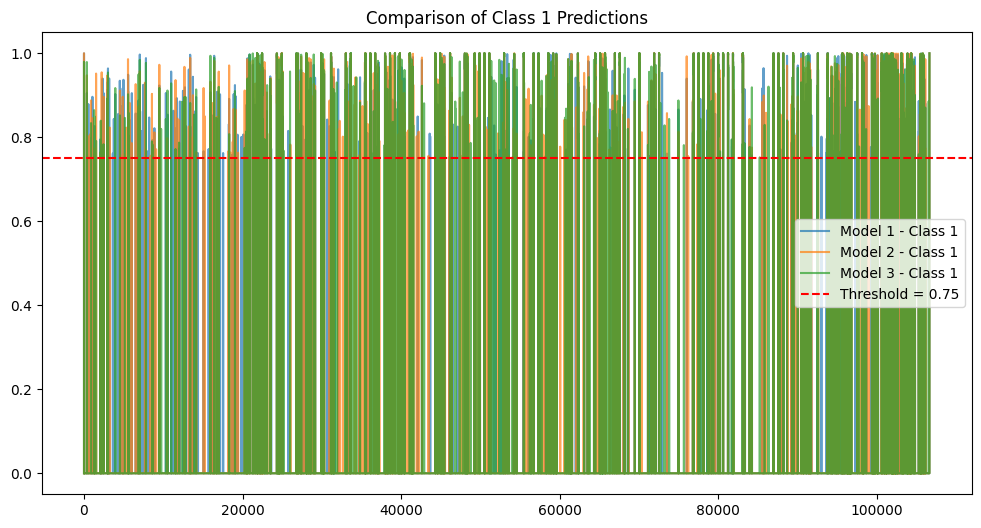

Number of valid frames after prior masking: 106207


In [102]:
# Process classified output
y_pred_splits = process_classified(y_pred_log_splits, prior, paths, 1)

print("Number of valid frames after prior masking:", np.sum(prior < 1))



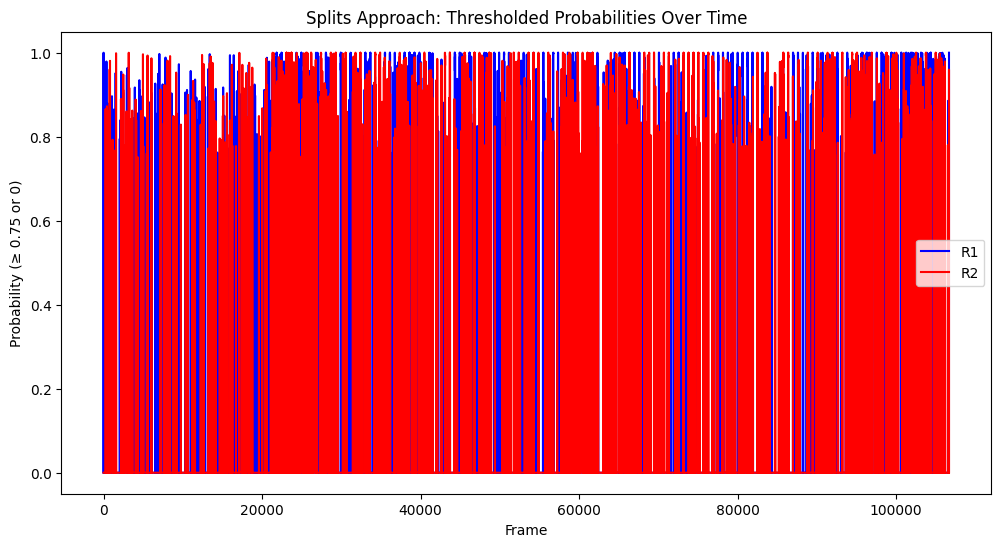

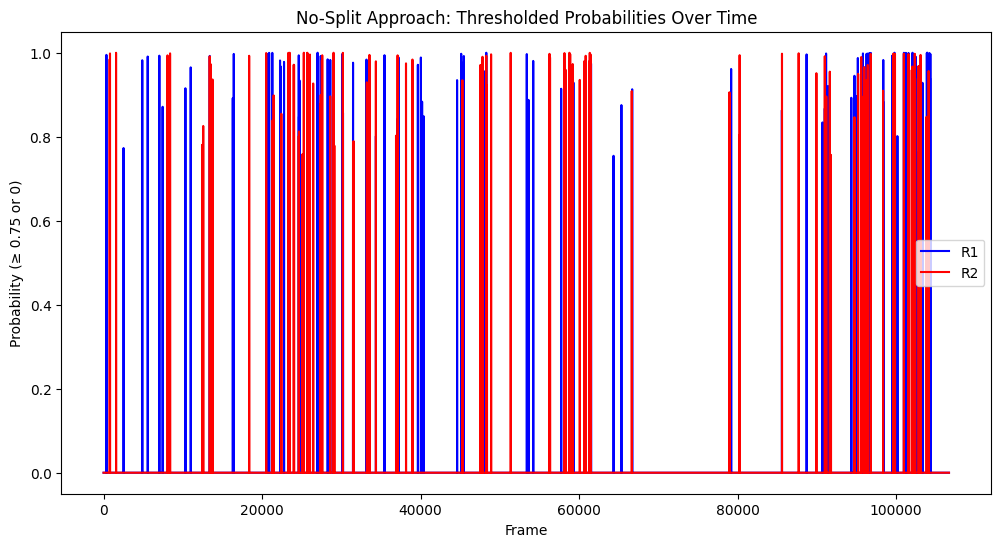

In [78]:
threshold = .75

splits_class1_thresh = np.where(y_pred_splits[:, 0] >= threshold,
                                y_pred_splits[:, 0], 
                                0)
splits_class2_thresh = np.where(y_pred_splits[:, 1] >= threshold,
                                y_pred_splits[:, 1], 
                                0)

nosplit_class1_thresh = np.where(y_pred_no_splits[:, 0] >= threshold,
                                 y_pred_no_splits[:, 0],
                                 0)
nosplit_class2_thresh = np.where(y_pred_no_splits[:, 1] >= threshold,
                                 y_pred_no_splits[:, 1],
                                 0)

# OPTIONAL: If the entire 106,665 frames is too large to visualize,
# pick a smaller slice for clarity:
#start, end = 0, 3000  # for example, first 3000 frames

plt.figure(figsize=(12,6))
plt.plot(splits_class1_thresh, 
         label='R1', color='blue')
plt.plot(splits_class2_thresh, 
         label='R2', color='red')

plt.xlabel('Frame')
plt.ylabel('Probability (≥ 0.75 or 0)')
plt.title('Splits Approach: Thresholded Probabilities Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot( nosplit_class1_thresh, 
         label='R1', color='blue')
plt.plot(nosplit_class2_thresh,
         label='R2', color='red')

plt.xlabel('Frame')
plt.ylabel('Probability (≥ 0.75 or 0)')
plt.title('No-Split Approach: Thresholded Probabilities Over Time')
plt.legend()
plt.show()


In [79]:
splits_class1_mask = y_pred_splits[:, 0] >= threshold
splits_class2_mask = y_pred_splits[:, 1] >= threshold

splits_class1_count = np.sum(splits_class1_mask)
splits_class2_count = np.sum(splits_class2_mask)

print(f"W/splits frames classified >= {threshold} for class 1: {splits_class1_count}")
print(f"W/splits splits frames classified >= {threshold} for class 2: {splits_class2_count}")

nosplit_class1_mask = y_pred_no_splits[:, 0] >= threshold
nosplit_class2_mask = y_pred_no_splits[:, 1] >= threshold

nosplit_class1_count = np.sum(nosplit_class1_mask)
nosplit_class2_count = np.sum(nosplit_class2_mask)

print(f"No split frames >= {threshold} for class 1: {nosplit_class1_count}")
print(f"No split frames >= {threshold} for class 2: {nosplit_class2_count}")

W/splits frames classified >= 0.75 for class 1: 3774
W/splits splits frames classified >= 0.75 for class 2: 3331
No split frames >= 0.75 for class 1: 173
No split frames >= 0.75 for class 2: 167


In [87]:
def classify_frames(prob_array, threshold=0.75):
    """
    Given prob_array of shape (n_frames, 2) -> [p_class1, p_class2],
    return integer labels: 0 (none), 1 (class1), or 2 (class2).
    If both >= threshold, pick whichever is higher; if equal, pick class1 or 2 arbitrarily.
    """
    n_frames = prob_array.shape[0]
    labels = np.zeros(n_frames, dtype=int)  # default = 0

    # Mask for class1 >= threshold
    class1_mask = prob_array[:, 0] >= threshold
    # Mask for class2 >= threshold
    class2_mask = prob_array[:, 1] >= threshold

    # Both >= threshold?
    both_mask = class1_mask & class2_mask

    # Class1 only
    labels[class1_mask & ~class2_mask] = 1
    # Class2 only
    labels[class2_mask & ~class1_mask] = 2

    # For frames where both pass threshold, pick whichever is higher probability
    # or pick class1 if tie
    for i in np.where(both_mask)[0]:
        if prob_array[i, 0] > prob_array[i, 1]:
            labels[i] = 1
        else:
            labels[i] = 2

    return labels

# Suppose you have y_pred_splits and y_pred_no_splits of shape (106665, 2)
splits_labels = classify_frames(y_pred_splits, threshold=threshold)
nosplit_labels = classify_frames(y_pred_no_splits, threshold=threshold)

print(nosplit_labels.shape)

df = pd.DataFrame({
    'splits': splits_labels,
    'no_splits': nosplit_labels
})

cross_tab = pd.crosstab(df['splits'], df['no_splits'], rownames=['Splits'], colnames=['No-Split'])
print(cross_tab)


(106665,)
No-Split      0    1    2
Splits                   
0         99507   29   24
1          3628  142    4
2          3190    2  139


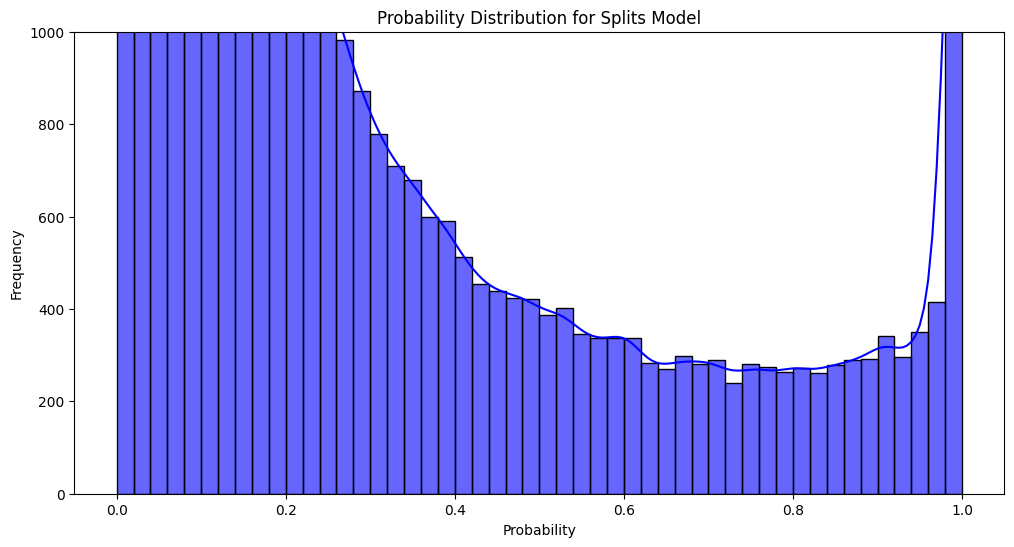

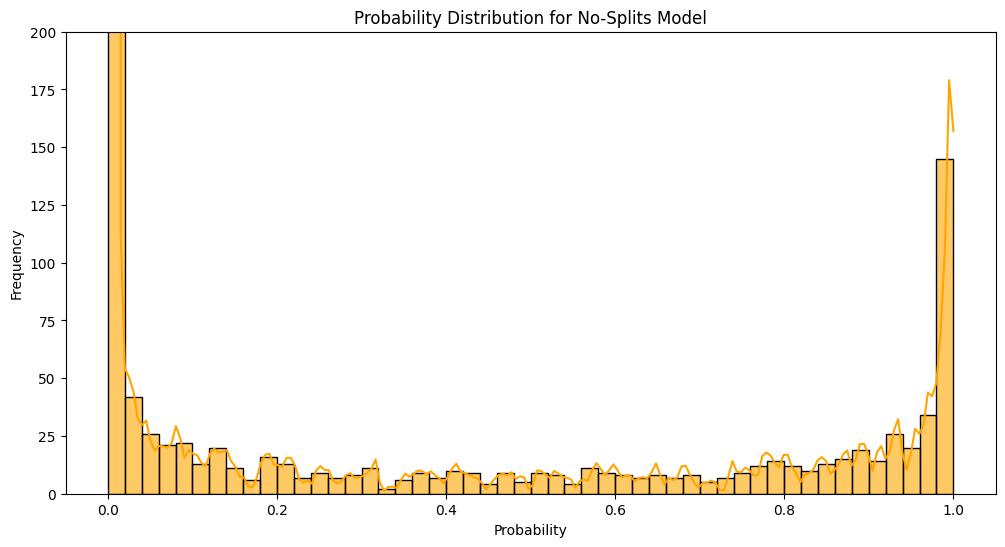

In [107]:
def plot_separate_probability_distributions(y_pred_splits, y_pred_no_splits):
    """
    Plots separate distributions of probabilities for all classes in 
    y_pred_splits and y_pred_no_splits.

    :param y_pred_splits: numpy array of shape (n_samples, 2), probabilities from splits
    :param y_pred_no_splits: numpy array of shape (n_samples, 2), probabilities from no splits
    """
    # Flatten the arrays to include both class 1 and class 2 probabilities
    splits_probs = y_pred_splits.flatten()
    no_splits_probs = y_pred_no_splits.flatten()

    # Plot for y_pred_splits
    plt.figure(figsize=(12, 6))
    sns.histplot(splits_probs, kde=True, color='blue', bins=50, alpha=0.6)
    plt.ylim(0,1000)
    plt.title('Probability Distribution for Splits Model')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

    # Plot for y_pred_no_splits
    plt.figure(figsize=(12, 6))
    sns.histplot(no_splits_probs, kde=True, color='orange', bins=50, alpha=0.6)
    plt.ylim(0, 200)
    plt.title('Probability Distribution for No-Splits Model')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

# Example usage:
plot_separate_probability_distributions(y_pred_splits, y_pred_no_splits)
